In [132]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt
from cvxopt import matrix

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [15]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""

X, y, keys = preprocess()

Feature size:  1464


In [16]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [166]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        lagrange_multipliers = self._compute_multipliers(X, y)
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias)
        
        for i, sample in enumerate(X):
            result[i] += self._kernel(self._weight_vector, sample)
        
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, _ = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        self._lagrange_multipliers = lagrange_multipliers[support_vector_indices]
        self._support_vectors = X[support_vector_indices]
        self._support_vector_labels = y[support_vector_indices]
    
        self._weight_vector = np.sum(
            self._lagrange_multipliers * self._support_vector_labels * self._support_vectors.T,
            axis=1
        )
        
        self._bias = sum(self._support_vector_labels - np.dot(self._support_vectors, self._weight_vector)) / len(support_vector_indices)
        

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, _ = X.shape
        K = self._kernel_matrix(X)
        
        H = matrix(K * np.outer(y, y)) # H[i, j] ] = K[i, j] * y[i] * y[j]
        f = matrix(-1.0, (N, 1)) # (-1,...,-1)^T

        A = matrix(np.vstack((np.eye(N), -np.eye(N)))) # (I | -I)^T
        a = matrix(np.hstack((np.full(N, self._c), np.zeros(N)))) # (c,...,c,0,...,0)^T

        B = matrix(y, (1, N))
        b = matrix(0.0)
        
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)
        
        # return the lagrange multipliers
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

[[ 0.17972892 -0.46535722  0.07755504 ... -0.03184202 -0.29607151
  -0.06232554]
 [-0.46535722  1.21200197 -0.27613521 ...  0.03155992  0.7450428
   0.24142364]
 [ 0.07755504 -0.27613521  0.8336834  ...  0.52682458  0.10117594
  -0.87726227]
 ...
 [-0.03184202  0.03155992  0.52682458 ...  0.37080489  0.20710417
  -0.56340057]
 [-0.29607151  0.7450428   0.10117594 ...  0.20710417  0.55322104
  -0.14061141]
 [-0.06232554  0.24142364 -0.87726227 ... -0.56340057 -0.14061141
   0.92527462]]
[ 1.80e-01 -4.65e-01  7.76e-02 -3.30e-02 -1.32e-01 -1.60e-01 -1.75e-01 ... ]
[-4.65e-01  1.21e+00 -2.76e-01  2.51e-02  2.78e-01  4.06e-01  3.45e-01 ... ]
[ 7.76e-02 -2.76e-01  8.34e-01  6.25e-01  6.07e-01  2.55e-02  1.08e+00 ... ]
[-3.30e-02  2.51e-02  6.25e-01  5.17e-01  5.54e-01  1.05e-01  9.54e-01 ... ]
[-1.32e-01  2.78e-01  6.07e-01  5.54e-01  6.46e-01  1.96e-01  1.08e+00 ... ]
[-1.60e-01  4.06e-01  2.55e-02  1.05e-01  1.96e-01  1.54e-01  2.92e-01 ... ]
[-1.75e-01  3.45e-01  1.08e+00  9.54e-01  1.08e

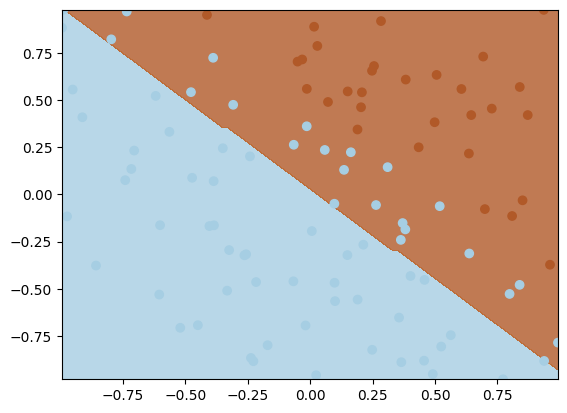

In [167]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  12


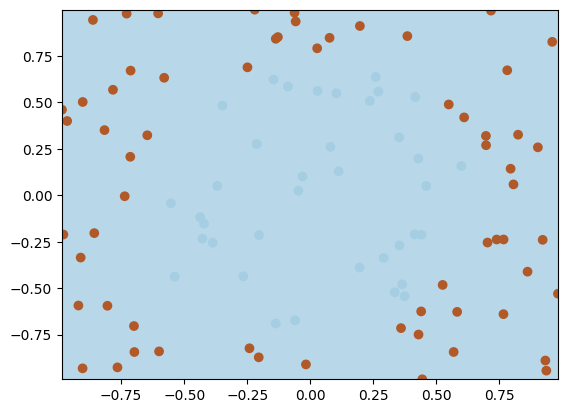

In [156]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [ ]:
opt_C = None
opt_acc = float('inf')

for C in [0.5, 1, 5, 10]:
   clf = SVM(Kernel.linear(), C)
   clf.fit(X['train'], y['train'].astype('double'))
   print("C = ", C)
   y_hat = clf.predict(X['train'])
   print("Acc on train: ", np.mean(y_hat == y['train']))
   y_hat = clf.predict(X['val'])
   print("Acc on val: ", np.mean(y_hat == y['val']))
   
   val_acc = np.mean(y_hat == y['val'])
   if val_acc < opt_acc:
      opt_acc = val_acc
      opt_C = C

Choose the best C, and predict the label for test data.

In [ ]:
C = opt_C
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)

RBF (Gaussian) kernel SVM

In [ ]:
for C in [RANGE OF C VALUES]:
    for gamma in [RANGE OF GAMMA VALUES]:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(X['val'])
        print("Acc on val: ", np.mean(y_hat == y['val']))
        

In [ ]:
clf = SVM(Kernel.gaussian(BEST GAMMA), BEST C)
clf.fit(X['train'], y['train'].astype('double'))y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)